In [1]:
pip install scikit-surprise

Note: you may need to restart the kernel to use updated packages.


In [2]:
from surprise import Dataset, Reader, SVD, SVDpp, accuracy, KNNBasic
import pandas as pd
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise.model_selection import train_test_split
from tqdm import tqdm
import logging
import math
from scipy.optimize import curve_fit
import operator
from scipy.spatial.distance import jensenshannon
import json
import pickle as pickle
from itertools import chain, combinations
import sys

In [3]:
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['userId', 'movieId', 'rating', 'timestamp'])
    
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16


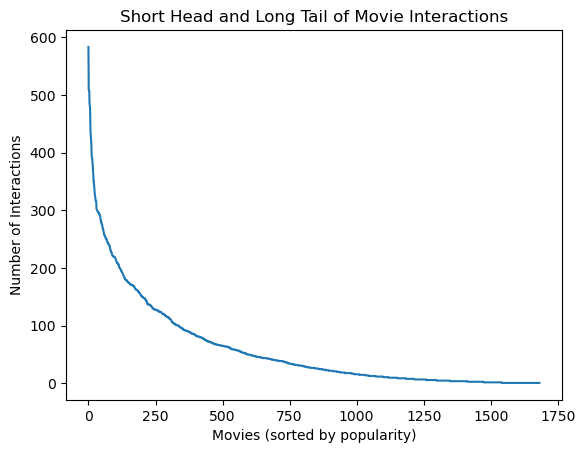

In [4]:
# Count ratings per movie and sort in descending order
movie_interactions = ratings['movieId'].value_counts().sort_values(ascending=False)

plt.plot(movie_interactions.values)
plt.title('Short Head and Long Tail of Movie Interactions')
plt.xlabel('Movies (sorted by popularity)')
plt.ylabel('Number of Interactions')
plt.show()


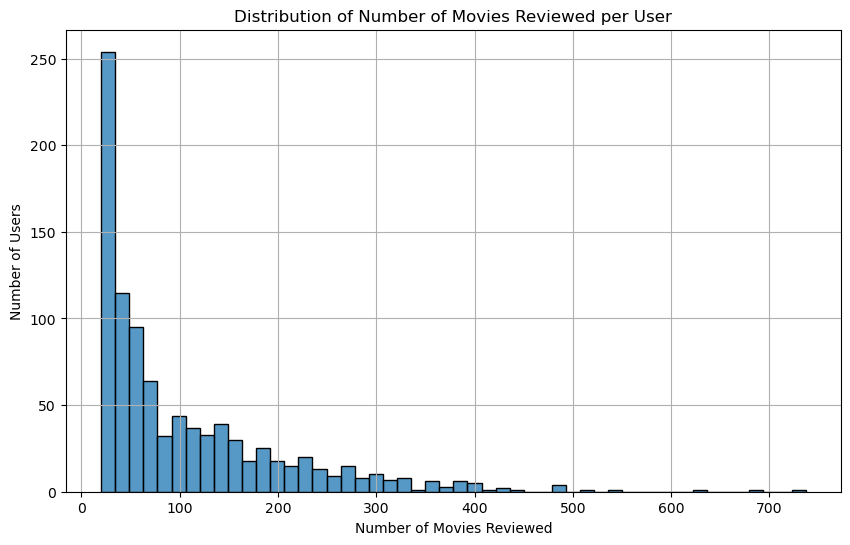

Number of users: 943


In [5]:
user_review_counts = ratings['userId'].value_counts()

plt.figure(figsize=(10, 6))
sns.histplot(user_review_counts, bins=50, kde=False)

plt.title('Distribution of Number of Movies Reviewed per User')
plt.xlabel('Number of Movies Reviewed')
plt.ylabel('Number of Users')
#plt.yscale('log') 
plt.grid(True)
plt.show()
print(f"Number of users: {ratings['userId'].nunique()}")


In [6]:
num_users = ratings['userId'].nunique()
num_items = ratings['movieId'].nunique()
num_interactions = len(ratings)

sparsity = 1 - (num_interactions / (num_users * num_items))
print(f"Sparsity of the dataset: {sparsity:.4f}")

Sparsity of the dataset: 0.9370


## SVD++ Model

In [7]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):

    # Map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (est, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, true_r) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    precision_avg = np.mean(list(precisions.values()))
    recall_avg = np.mean(list(recalls.values()))

    return precision_avg, recall_avg

In [8]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    #array += 0.0000001
    np.add(array, 0.0000001, out=array, casting="unsafe")
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [9]:
def calculate_gini_of_recommendations(predictions):
    # Count the number of recommendations for each movie
    recommendation_count = Counter([pred.iid for pred in predictions])
    
    # Convert the counts to a numpy array
    recommendation_array = np.array(list(recommendation_count.values()))
    
    gini_index = gini(recommendation_array)
    return gini_index

In [10]:
def arp_(users, recs, popularity):
    num_users = len(users)
    res = 1/num_users
    users_sum = 0
    for user in users:
        rec = recs[user]
        popularity_sum = 0
        for item in rec:
            p = popularity[int(item)]
            popularity_sum += p
        popularity_sum = popularity_sum/len(rec)
        users_sum += popularity_sum
    res = res * users_sum
    return res


In [11]:
def aplt(users, recs, long_tail):
    num_users = len(users)
    res = 1/num_users
    users_sum = 0
    for user in users:
        rec = recs[user]
        num_long_tail = len(set(long_tail).intersection(set(rec)))
        users_sum += num_long_tail/len(rec)
    res = res * users_sum
    return res

In [12]:
logging.basicConfig(
    format="%(asctime)s - %(message)s",
    level=logging.INFO,
    handlers=[logging.StreamHandler()]
)

def split_by_month(df, start_date, end_date):
    train_df = df[(df['timestamp'] >= start_date) & (df['timestamp'] < end_date)]
    test_df = df[df['timestamp'] >= end_date]

    # Ensure that the test set contains only users and items from the train set
    test_df = test_df[test_df['userId'].isin(train_df['userId']) & test_df['movieId'].isin(train_df['movieId'])]

    reader = Reader(rating_scale=(1, 5))

    train_data = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader)

    trainset = train_data.build_full_trainset()

    testset = list(test_df[['userId', 'movieId', 'rating']].itertuples(index=False, name=None))
    

    return trainset, testset, train_df, test_df

In [13]:
def evaluate_over_months(ratings, num_months):
    results = []
    recommendations = []
    popularity = ratings['movieId'].value_counts(normalize=True).to_dict()  # Popularity based on rating counts
    #popularity = ratings['movieId'].value_counts().to_dict()
    max_popularity = max(popularity.values())
    popularity = {k: v / max_popularity for k, v in popularity.items()}
    
    long_tail_threshold = 0.2  # Define the long-tail threshold
    long_tail_items = [movie for movie, popularity in popularity.items() if popularity < long_tail_threshold]

    
    start_date = ratings['timestamp'].min()

    for month_n in range(1, num_months + 1):
        end_date = start_date + pd.DateOffset(months=1)
        logging.info(f"Processing month {month_n} ({start_date.date()} to {end_date.date()})...")
        
        trainset, testset, train_df, test_df = split_by_month(ratings, start_date, end_date)

        model = SVDpp()
        logging.info(f"Starting training for month {month_n}...")
        model.fit(trainset)
        logging.info(f"Training complete for month {month_n}.")

        predictions = model.test(testset)

        rmse = accuracy.rmse(predictions, verbose=False)
        precision, recall = precision_recall_at_k(predictions, k=10)
        gini_index = calculate_gini_of_recommendations(predictions)

        logging.info(f"month {month_n} RMSE: {rmse:.4f}")

        active_users = train_df['userId'].unique()
        movie_ids = ratings['movieId'].unique()
        recs = {}  # Dictionary to store recommendations for each user

        logging.info(f"Generating recommendations for {len(active_users)} active users in month {month_n}...")
        for user_id in tqdm(active_users, desc=f"Recommending for month {month_n}"):
            user_recommendations = []

            for movie_id in movie_ids:
                if len(ratings[(ratings['userId'] == user_id) & (ratings['movieId'] == movie_id)]) == 0:
                    predicted_rating = model.predict(user_id, movie_id).est
                    user_recommendations.append((movie_id, predicted_rating))

            # Sort recommendations by predicted rating and take top 10
            top_recommendations = sorted(user_recommendations, key=lambda x: x[1], reverse=True)[:100]
            recs[user_id] = [rec[0] for rec in top_recommendations]

            # Extend recommendations for saving
            recommendations.extend([(user_id, rec[0], rec[1], month_n) for rec in top_recommendations])

        arp_value = arp_(active_users, recs, popularity)
        
        aplt_value = aplt(active_users, recs, long_tail_items)

        results.append({
            'month': month_n,
            'rmse': rmse,
            'num_active_users': len(active_users),
            'precision@10': precision,
            'recall@10': recall,
            'gini_index': gini_index,
            'arp': arp_value,
            'aplt': aplt_value,
        })

        start_date = end_date

    # Save original recommendations
    recommendations_df = pd.DataFrame(recommendations, columns=['userId', 'movieId', 'rating', 'month'])
    recommendations_df.to_csv("monthly_recommendations.csv", index=False)


    return results, recommendations_df


## Calibrated Popularity

In [14]:
def calib_rec_greedy(recs, alpha, k):
    reranked = []
    users=recs.userId.unique()

    for u in tqdm(users):
        #print("------------------------------------------------------")
        user_recs = recs.loc[recs['userId'] == u]
        user_recs = user_recs.drop_duplicates(subset=['movieId'])
        
        rating_dict = {}
        for index, row in user_recs.iterrows():
            rating_dict[row['movieId']] = row["rating"]

        #og user probabilities
        rated = UG_tolerance_map[u]

        #get all the items recommended for the user in ALS100
        items = user_recs.movieId.unique()

        T = items[:10]
        X = items[10:]

        old_list = items[:10]
        #print("User:", u, "; Original list:", old_list)
        new_list = items[:10]
        for index in range(1, 11):
            #print(index)
            #print("Old list:", old_list)
            delta = 0
            new_list = old_list.copy()
            init_cp = cp(old_list, rated, rating_dict, 0.9)
            #print("Init CP:", init_cp)
            for i in X:
                new_list[-index] = i
                new_cp = cp(new_list, rated, rating_dict, 0.9)
                #print("Item:", i, "\nNew list:", new_list, "\nCP score:", new_cp)
                if new_cp-init_cp>delta:
                    '''print("******************************")
                    print("Found better CP value!")
                    print("List:", new_list)
                    print("CP score:", new_cp)
                    print("******************************")'''
                    old_list = new_list.copy()
                    delta = new_cp-init_cp
            #print("=========================")


        #print("Best list candidate:", better_list)
        #reranked[u] = better_list
        for item in old_list:
            score = user_recs.loc[user_recs['movieId'] == item, 'rating'].item()
            #print("rating:", score)
            d = {'userId':u, 'movieId':item, 'rating':score}
            #print(d)
            reranked.append(d)

    return reranked

In [15]:
#=====================================================================
#METHODS
#method to categorize users into mainstream, niche and in-between
#takes original rating dataset as a parameter, returns a dict with user IDs and popularity group they belong to
def user_tol_cat(df):
    UG_map={}
    for u in users:
        UG1=[]
        UG2=[]
        UG3=[]
        rated=df[df.userId==u]['movieId']
        for i in rated:
            if i in G[0]:
                UG1.append(i)
            elif i in G[1]:
                UG2.append(i)
            else:
                UG3.append(i)
        UG_map[u]=[len(UG1),len(UG2),len(UG3)]

    UG_tolerance_map={}
    for u in users:
        u_g=UG_map[u]
        s=sum(u_g)
        UG_tolerance_map[u]=[float(x)/s for x in u_g]
    return UG_tolerance_map



# figure out what item index in an ordered list would be a cut-off point for a certain percentage
def find_short_head_split_point(sorted_list,percentage):
    s=0.0
    eightyPercent=float(sum(sorted_list))*percentage
    for i in range(len(sorted_list)):
        s+=sorted_list[i]
        if s>=eightyPercent:
            return i

# this method does the calculation magic - checks the relevance of the newly re-ranked list, as well as divergence between recommendation vector and user vector
def cp(recom, rated, rating_dict, alpha):

    UG_map=[len(set(G[0]).intersection(set(recom))),len(set(G[1]).intersection(set(recom))),len(set(G[2]).intersection(set(recom)))]
    UG_map = [float(x)/10 for x in UG_map]

    relevance_sum = 0
    for i in recom:
        rating = rating_dict[i]
        relevance_sum += rating

    left = (1-alpha)*relevance_sum
    j = jensenshannon(rated,UG_map)
    right = alpha*j
    res = left-right
    return res

def cali(recs100, alpha, k, month):
    print(f"Adding 'month' column for month {month}...")
    recs100['month'] = month  
    print("Checking recs100 before reranking:")
    print(recs100.head())  

    print("####### Starting the reranking...")
    reranked = calib_rec_greedy(recs100, alpha, k)
    
    # Check if reranked is a DataFrame, if not, convert it to one
    if not isinstance(reranked, pd.DataFrame):
        reranked = pd.DataFrame(reranked, columns=['userId', 'movieId', 'rating'])

    print("Checking reranked DataFrame:")
    print(reranked.head())  # Check if 'month' column is still there
    
    reranked['month'] = month  # Add the 'month' column manually here
    print("Checking reranked DataFrame after adding 'month':")
    print(reranked.head())

    reranked.to_csv(res_path, index=False)
    return reranked


In [16]:
alpha = 0.9
k = 10

# list of user IDs for utility
users = []
res_path = "svd_re-ranking"

In [17]:
# save a list of user IDs in a utility variable we have above for future use, it will come handy
users=ratings.userId.unique()

# calculate item popularities in the original rating dataset
item_pops=ratings.groupby('movieId').size()/len(ratings.userId.unique())
#item_pops.head()
item_pops_total=ratings.groupby('movieId').size()

sorted_item_pops_map = sorted(item_pops_total.items(),reverse=True,key=operator.itemgetter(1))
sorted_items=[x[0] for x in sorted_item_pops_map]
sorted_ratio=[x[1] for x in sorted_item_pops_map]

# find out where are the thresholds between head and mid items, mid and tail items
short_head_point=find_short_head_split_point(sorted(item_pops,reverse=True),0.2)
mid_tail_point=find_short_head_split_point(sorted(item_pops,reverse=True),0.8)

# put items into separate popularity groups
indexes=[short_head_point,mid_tail_point,len(item_pops)]
global G
G =[]
s=0
for i in range(len(indexes)):
    G.append([x[0] for x in sorted_item_pops_map[s:int(indexes[i])]])
    s=int(indexes[i])
G_names=[]
for i in range(len(G)):
    G_names.append("G%s"%(i+1))

# just double checking the lists of items with different popularites
print("Lengths of G lists:")
for l in G:
    print(len(l))

# now we can split the users into different groups based on their popularity preference too
# we will need the original rating dataset for this too
print("Calculating original user tolerance map...")
global UG_tolerance_map
UG_tolerance_map=user_tol_cat(ratings)

Lengths of G lists:
58
477
1147
Calculating original user tolerance map...


In [18]:
# Convert to a list of tolerance distributions
tolerances = list(UG_tolerance_map.values())

# Convert to a NumPy array for easier analysis
tolerance_array = np.array(tolerances)

# Calculate mean tolerance for each category (e.g., Head, Mid, Tail)
mean_tolerance = tolerance_array.mean(axis=0)
print(f"Mean tolerance: {mean_tolerance}")

# Check variance or standard deviation
std_tolerance = tolerance_array.std(axis=0)
print(f"Standard deviation: {std_tolerance}")

Mean tolerance: [0.25545736 0.58042645 0.16411619]
Standard deviation: [0.10885524 0.08825771 0.10299894]


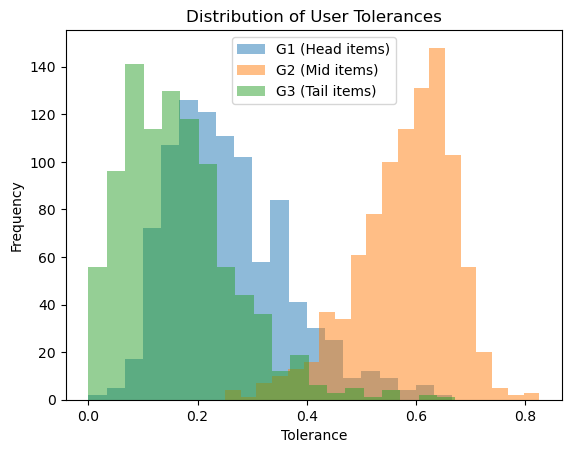

In [19]:
# Create separate lists for each category (e.g., G1, G2, G3)
g1, g2, g3 = tolerance_array.T  # Transpose to split into groups

# Plot histograms for each category
plt.hist(g1, bins=20, alpha=0.5, label="G1 (Head items)")
plt.hist(g2, bins=20, alpha=0.5, label="G2 (Mid items)")
plt.hist(g3, bins=20, alpha=0.5, label="G3 (Tail items)")

plt.title("Distribution of User Tolerances")
plt.xlabel("Tolerance")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## Running the model

In [20]:
if __name__ == "__main__":    
    num_months = 7
    monthly_results, recommendations_df = evaluate_over_months(ratings, num_months)

    # Loop over each month and apply CP re-ranking
    all_reranked_recommendations = []
    for month in range(1, num_months + 1):
        print(f"Processing month {month}...")
        monthly_recommendations = recommendations_df[recommendations_df['month'] == month]  # Filter recommendations for the month
        
        print(f"Checking monthly recommendations for month {month}:")
        print(monthly_recommendations.head())  # Verify 'month' column exists here

        # Apply CP re-ranking
        logging.info(f"Applying CP re-ranking for month {month}...")
        reranked_recommendations = cali(monthly_recommendations, alpha, k, month)

        # Add to the list of reranked recommendations
        all_reranked_recommendations.append(reranked_recommendations)

    # Combine all reranked recommendations into a single DataFrame
    reranked_df = pd.concat(all_reranked_recommendations, ignore_index=True)

    # Check if the 'month' column is preserved in the final DataFrame
    print("Checking final reranked_df:")
    print(reranked_df.head())

    reranked_df.to_csv("monthly_reranked_recommendations.csv", index=False)

    print(pd.DataFrame(monthly_results))

2024-12-10 19:09:09,039 - Processing month 1 (1997-09-20 to 1997-10-20)...
2024-12-10 19:09:09,056 - Starting training for month 1...
2024-12-10 19:09:10,007 - Training complete for month 1.
2024-12-10 19:09:10,190 - month 1 RMSE: 1.0762
2024-12-10 19:09:10,191 - Generating recommendations for 157 active users in month 1...
Recommending for month 1: 100%|███████████████| 157/157 [00:57<00:00,  2.74it/s]
2024-12-10 19:10:07,577 - Processing month 2 (1997-10-20 to 1997-11-20)...
2024-12-10 19:10:07,591 - Starting training for month 2...
2024-12-10 19:10:08,769 - Training complete for month 2.
2024-12-10 19:10:08,924 - month 2 RMSE: 1.0351
2024-12-10 19:10:08,925 - Generating recommendations for 262 active users in month 2...
Recommending for month 2: 100%|███████████████| 262/262 [01:33<00:00,  2.81it/s]
2024-12-10 19:11:42,263 - Processing month 3 (1997-11-20 to 1997-12-20)...
2024-12-10 19:11:42,275 - Starting training for month 3...
2024-12-10 19:11:43,461 - Training complete for mont

Processing month 1...
Checking monthly recommendations for month 1:
   userId  movieId    rating  month
0     200      114  5.000000      1
1     200      408  4.959418      1
2     200       64  4.832196      1
3     200      189  4.775138      1
4     200      180  4.764038      1
Adding 'month' column for month 1...
Checking recs100 before reranking:
   userId  movieId    rating  month
0     200      114  5.000000      1
1     200      408  4.959418      1
2     200       64  4.832196      1
3     200      189  4.775138      1
4     200      180  4.764038      1
####### Starting the reranking...


100%|█████████████████████████████████████████| 157/157 [00:03<00:00, 40.29it/s]
2024-12-10 19:17:41,628 - Applying CP re-ranking for month 2...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_66415/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0     200      114  5.000000
1     200      408  4.959418
2     200       64  4.832196
3     200      189  4.775138
4     200      180  4.764038
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0     200      114  5.000000      1
1     200      408  4.959418      1
2     200       64  4.832196      1
3     200      189  4.775138      1
4     200      180  4.764038      1
Processing month 2...
Checking monthly recommendations for month 2:
       userId  movieId    rating  month
15700      22       64  5.000000      2
15701      22      318  4.994521      2
15702      22      408  4.925078      2
15703      22      357  4.920600      2
15704      22      169  4.889148      2
Adding 'month' column for month 2...
Checking recs100 before reranking:
       userId  movieId    rating  month
15700      22       64  5.000000      2
15701      22      318  4.994521      2
15702      22      408  4.92507

 42%|█████████████████▎                       | 111/262 [00:02<00:03, 38.92it/s]/Users/bjornmorch/anaconda3/lib/python3.11/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
100%|█████████████████████████████████████████| 262/262 [00:06<00:00, 38.98it/s]
2024-12-10 19:17:48,365 - Applying CP re-ranking for month 3...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_66415/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0      22       64  5.000000
1      22      318  4.994521
2      22      408  4.925078
3      22      945  4.491984
4      22      169  4.889148
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      22       64  5.000000      2
1      22      318  4.994521      2
2      22      408  4.925078      2
3      22      945  4.491984      2
4      22      169  4.889148      2
Processing month 3...
Checking monthly recommendations for month 3:
       userId  movieId    rating  month
41900     196      318  4.447754      3
41901     196       64  4.346555      3
41902     196      474  4.326587      3
41903     196      603  4.314376      3
41904     196       50  4.290885      3
Adding 'month' column for month 3...
Checking recs100 before reranking:
       userId  movieId    rating  month
41900     196      318  4.447754      3
41901     196       64  4.346555      3
41902     196      474  4.32658

100%|█████████████████████████████████████████| 187/187 [00:04<00:00, 39.03it/s]
2024-12-10 19:17:53,168 - Applying CP re-ranking for month 4...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_66415/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0     196      318  4.447754
1     196       64  4.346555
2     196      474  4.326587
3     196      603  4.314376
4     196      589  4.164405
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0     196      318  4.447754      3
1     196       64  4.346555      3
2     196      474  4.326587      3
3     196      603  4.314376      3
4     196      589  4.164405      3
Processing month 4...
Checking monthly recommendations for month 4:
       userId  movieId    rating  month
60600     298      272  4.898448      4
60601     298      408  4.894325      4
60602     298      124  4.870059      4
60603     298       12  4.849243      4
60604     298       64  4.728623      4
Adding 'month' column for month 4...
Checking recs100 before reranking:
       userId  movieId    rating  month
60600     298      272  4.898448      4
60601     298      408  4.894325      4
60602     298      124  4.87005

 73%|██████████████████████████████           | 162/221 [00:04<00:01, 39.87it/s]/Users/bjornmorch/anaconda3/lib/python3.11/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
100%|█████████████████████████████████████████| 221/221 [00:05<00:00, 39.23it/s]
2024-12-10 19:17:58,812 - Applying CP re-ranking for month 5...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_66415/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0     298      272  4.898448
1     298      408  4.894325
2     298      124  4.870059
3     298       12  4.849243
4     298       64  4.728623
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0     298      272  4.898448      4
1     298      408  4.894325      4
2     298      124  4.870059      4
3     298       12  4.849243      4
4     298       64  4.728623      4
Processing month 5...
Checking monthly recommendations for month 5:
       userId  movieId    rating  month
82700     166      408  4.647773      5
82701     166      272  4.557443      5
82702     166      196  4.452301      5
82703     166      709  4.406405      5
82704     166      483  4.353274      5
Adding 'month' column for month 5...
Checking recs100 before reranking:
       userId  movieId    rating  month
82700     166      408  4.647773      5
82701     166      272  4.557443      5
82702     166      196  4.45230

100%|█████████████████████████████████████████| 182/182 [00:04<00:00, 40.06it/s]
2024-12-10 19:18:03,366 - Applying CP re-ranking for month 6...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_66415/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0     166      408  4.647773
1     166      272  4.557443
2     166      196  4.452301
3     166      709  4.406405
4     166       64  4.262230
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0     166      408  4.647773      5
1     166      272  4.557443      5
2     166      196  4.452301      5
3     166      709  4.406405      5
4     166       64  4.262230      5
Processing month 6...
Checking monthly recommendations for month 6:
        userId  movieId    rating  month
100900     224       64  4.248821      6
100901     224       50  4.134988      6
100902     224      181  4.094881      6
100903     224       12  4.066346      6
100904     224       42  4.060700      6
Adding 'month' column for month 6...
Checking recs100 before reranking:
        userId  movieId    rating  month
100900     224       64  4.248821      6
100901     224       50  4.134988      6
100902     224      18

 89%|████████████████████████████████████▋    | 160/179 [00:04<00:00, 40.15it/s]/Users/bjornmorch/anaconda3/lib/python3.11/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
100%|█████████████████████████████████████████| 179/179 [00:04<00:00, 39.96it/s]
2024-12-10 19:18:07,856 - Applying CP re-ranking for month 7...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_66415/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0     224       64  4.248821
1     224      900  3.829599
2     224       87  3.920286
3     224      185  3.920447
4     224       42  4.060700
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0     224       64  4.248821      6
1     224      900  3.829599      6
2     224       87  3.920286      6
3     224      185  3.920447      6
4     224       42  4.060700      6
Processing month 7...
Checking monthly recommendations for month 7:
        userId  movieId    rating  month
118800     186       50  4.856308      7
118801     186      318  4.683837      7
118802     186       89  4.572972      7
118803     186      174  4.558451      7
118804     186      172  4.454162      7
Adding 'month' column for month 7...
Checking recs100 before reranking:
        userId  movieId    rating  month
118800     186       50  4.856308      7
118801     186      318  4.683837      7
118802     186       8

100%|█████████████████████████████████████████| 244/244 [00:06<00:00, 39.34it/s]

Checking reranked DataFrame:
   userId  movieId    rating
0     186       50  4.856308
1     186      318  4.683837
2     186      491  4.412188
3     186      513  4.409089
4     186       61  4.218528
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0     186       50  4.856308      7
1     186      318  4.683837      7
2     186      491  4.412188      7
3     186      513  4.409089      7
4     186       61  4.218528      7
Checking final reranked_df:
   userId  movieId    rating  month
0     200      114  5.000000      1
1     200      408  4.959418      1
2     200       64  4.832196      1
3     200      189  4.775138      1
4     200      180  4.764038      1
   month      rmse  num_active_users  precision@10  recall@10  gini_index  \
0      1  1.076222               157      0.724567   0.369075    0.443056   
1      2  1.035139               262      0.663630   0.368095    0.415207   
2      3  1.050107               187      0.648077   0.4

In [21]:
reranked_df.head()

,userId,movieId,rating,month
0,200,114,5.000000,1
1,200,408,4.959418,1
2,200,64,4.832196,1
3,200,189,4.775138,1
4,200,180,4.764038,1


In [22]:
for result in monthly_results:
    print(f"month {result['month']}: RMSE = {result['rmse']:.4f} - Precision@10: {result['precision@10']:.4f}, "
          f"Recall@10: {result['recall@10']:.4f}, Active Users = {result['num_active_users']}, "
          f"Gini Index of Recommendations = {result['gini_index']:.4f}, "
          f"ARP = {result['arp']:.4f}, "
          f"APLT = {result['aplt']:.4f}") 

month 1: RMSE = 1.0762 - Precision@10: 0.7246, Recall@10: 0.3691, Active Users = 157, Gini Index of Recommendations = 0.4431, ARP = 0.2724, APLT = 0.3709
month 2: RMSE = 1.0351 - Precision@10: 0.6636, Recall@10: 0.3681, Active Users = 262, Gini Index of Recommendations = 0.4152, ARP = 0.2469, APLT = 0.4581
month 3: RMSE = 1.0501 - Precision@10: 0.6481, Recall@10: 0.4383, Active Users = 187, Gini Index of Recommendations = 0.3942, ARP = 0.2328, APLT = 0.5053
month 4: RMSE = 1.0123 - Precision@10: 0.6499, Recall@10: 0.4951, Active Users = 221, Gini Index of Recommendations = 0.3913, ARP = 0.2627, APLT = 0.4069
month 5: RMSE = 1.0065 - Precision@10: 0.6619, Recall@10: 0.4985, Active Users = 182, Gini Index of Recommendations = 0.4083, ARP = 0.2572, APLT = 0.4154
month 6: RMSE = 1.2118 - Precision@10: 0.5007, Recall@10: 0.4010, Active Users = 179, Gini Index of Recommendations = 0.3027, ARP = 0.2601, APLT = 0.3849
month 7: RMSE = 1.1765 - Precision@10: 0.4750, Recall@10: 0.3821, Active Use

## Metrics for CP re-ranking technique

In [23]:
def calculate_gini_of_recommendations_cp(movie_ids):
    # Count the number of recommendations for each movie
    recommendation_count = Counter(movie_ids)
    
    # Convert the counts to a numpy array
    recommendation_array = np.array(list(recommendation_count.values()))
    
    gini_index = gini(recommendation_array)
    return gini_index

In [24]:
def calculate_arp(reranked_df, item_popularity):
    # Group recommendations by user
    recs = reranked_df.groupby('userId')['movieId'].apply(list).to_dict()
    users = list(recs.keys())  # Get all user IDs from the re-ranked dataset
    
    # Compute APLT using the provided function
    arp_value = arp_(users, recs, item_popularity)
    return arp_value

In [25]:
def calculate_aplt(reranked_df, long_tail_items):
    # Group recommendations by user
    recs = reranked_df.groupby('userId')['movieId'].apply(list).to_dict()
    users = list(recs.keys())  # Get all user IDs from the re-ranked dataset
    
    # Compute APLT using the provided function
    aplt_value = aplt(users, recs, long_tail_items)
    return aplt_value

In [26]:
item_popularity = ratings['movieId'].value_counts(normalize=True).to_dict()

In [27]:
max_popularity = max(item_popularity.values())
item_popularity = {k: v / max_popularity for k, v in item_popularity.items()}
long_tail_threshold = 0.2
long_tail_items = [movie for movie, popularity in item_popularity.items() if popularity < long_tail_threshold]

In [28]:
results = []

for month in reranked_df['month'].unique():
    month_data = reranked_df[reranked_df['month'] == month]
    movie_ids = month_data['movieId'].tolist()
    
    gini_index = calculate_gini_of_recommendations_cp(movie_ids)
    monthly_arp = calculate_arp(month_data, item_popularity)
    monthly_aplt = calculate_aplt(month_data, long_tail_items)
    
    results.append({"month": month, "gini_index": gini_index, "arp": monthly_arp, "aplt": monthly_aplt})

results_df = pd.DataFrame(results)

print(results_df)

results_df.to_csv("beyond_accuracy_per_month.csv", index=False)

   month  gini_index       arp      aplt
0      1    0.720453  0.304512  0.360510
1      2    0.727990  0.303862  0.378244
2      3    0.699272  0.302016  0.250267
3      4    0.756232  0.313419  0.296833
4      5    0.695580  0.301131  0.368132
5      6    0.723671  0.303857  0.258659
6      7    0.715517  0.286141  0.392623


## Main model and CP re-ranking graphs

In [29]:
months = [result['month'] for result in monthly_results]

rmse_values = [result['rmse'] for result in monthly_results]

precision_values = [result['precision@10'] for result in monthly_results]

recall_values = [result['recall@10'] for result in monthly_results]

gini_values = [result['gini_index'] for result in monthly_results]

user_values = [result['num_active_users'] for result in monthly_results]

arp = [result['arp'] for result in monthly_results]

aplt = [result['aplt'] for result in monthly_results]

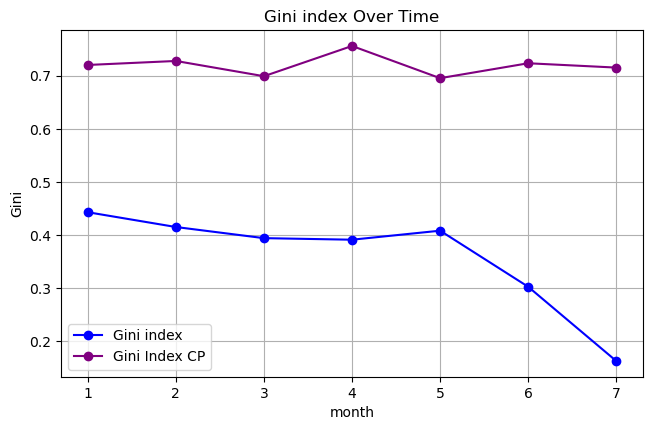

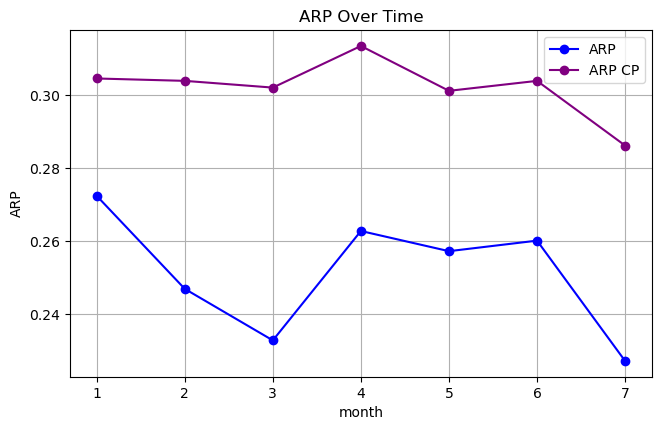

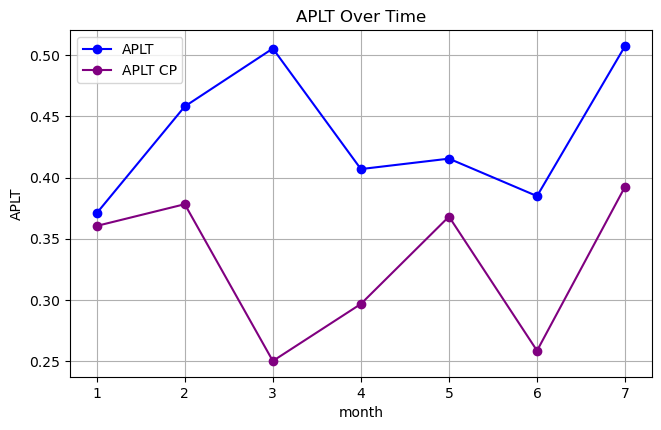

In [30]:
#Gini
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, gini_values, marker='o', color='b', label='Gini index')
plt.plot(results_df['month'], results_df['gini_index'], marker='o', color='purple', label='Gini Index CP')
plt.title('Gini index Over Time')
plt.xlabel('month')
plt.ylabel('Gini')
plt.grid(True)
plt.legend()
plt.show()

#arp
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, arp, marker='o', color='b', label='ARP')
plt.plot(results_df['month'], results_df['arp'], marker='o', color='purple', label='ARP CP')
plt.title('ARP Over Time')
plt.xlabel('month')
plt.ylabel('ARP')
plt.grid(True)
plt.legend()
plt.show()

#Aplt
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, aplt, marker='o', color='b', label='APLT')
plt.plot(results_df['month'], results_df['aplt'], marker='o', color='purple', label='APLT CP')
plt.title('APLT Over Time')
plt.xlabel('month')
plt.ylabel('APLT')
plt.grid(True)
plt.legend()
plt.show()

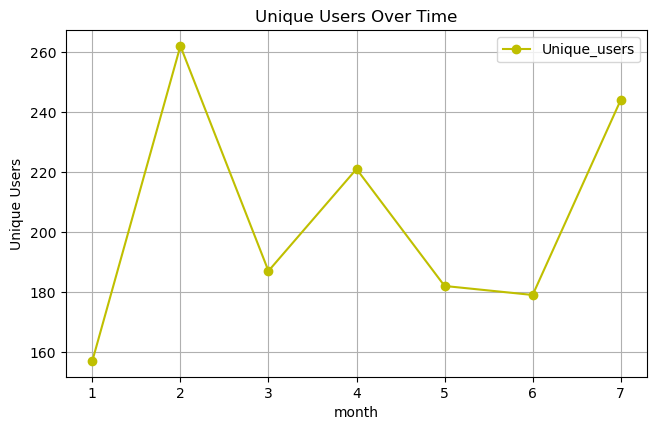

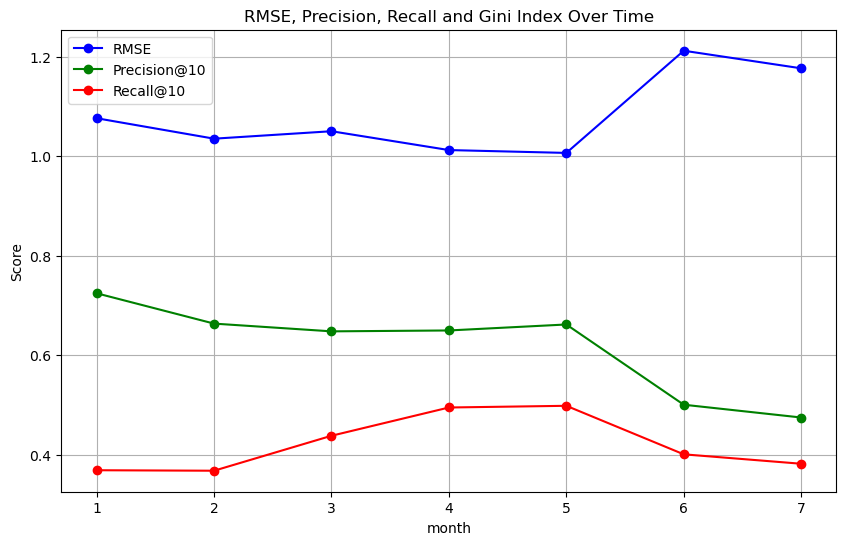

In [31]:
#Unique Users
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, user_values, marker='o', color='y', label='Unique_users')
plt.title('Unique Users Over Time')
plt.xlabel('month')
plt.ylabel('Unique Users')
plt.grid(True)
plt.legend()
plt.show()


#RMSE, Precision and Recall
plt.figure(figsize=(10, 6))
plt.plot(months, rmse_values, marker='o', color='b', label='RMSE')
plt.plot(months, precision_values, marker='o', color='g', label='Precision@10')
plt.plot(months, recall_values, marker='o', color='r', label='Recall@10')

plt.title('RMSE, Precision, Recall and Gini Index Over Time')
plt.xlabel('month')
plt.ylabel('Score')
plt.grid(True)
plt.legend()
plt.show()